In [1]:
import utils
import pandas as pd
import plotly.express as px
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

color_discrete_map = {
    "Compound": "rgb(0,114,178)",
    "CRISPR": "rgb(213,94,0)",
    "ORF": "rgb(0,158,115)",
}

color_discrete_map_seaborn = {
    "Compound": "#0072b2",
    "CRISPR": "#d55e00",
    "ORF": "#009e73",
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

%matplotlib inline

In [2]:
batches = [
    "2020_11_04_CPJUMP1",
    "2020_11_18_CPJUMP1_TimepointDay1",
    "2020_11_19_TimepointDay4",
    "2020_12_02_CPJUMP1_2WeeksTimePoint",
    "2020_12_07_CPJUMP1_4WeeksTimePoint",
    "2020_12_08_CPJUMP1_Bleaching",
]

experiment_df = pd.read_csv("output/experiment-metadata.tsv", sep="\t")

In [3]:
# Read all the plates

all_plates_df = pd.DataFrame()
for batch in batches:
    batches_df = experiment_df.query("Batch==@batch")
    for modality in batches_df.Perturbation.unique():
        modality_df = batches_df.query("Perturbation==@modality")
        for cell in modality_df.Cell_type.unique():
            cell_df = modality_df.query('Cell_type==@cell')
            for time_point in cell_df.Time.unique():
                time_df = cell_df.query("Time==@time_point")
                for plate in time_df.Assay_Plate_Barcode.unique():
                    cell_line = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Cell_line"].values[0]
                    time_delay = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Time_delay"].values[0]
                    times_imaged = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Times_imaged"].values[0]
                    density = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Density"].values[0]
                    antibiotics = time_df.loc[time_df.Assay_Plate_Barcode==plate, "Antibiotics"].values[0]
                    data_df = (
                        utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                        .assign(Metadata_batch=batch)
                        .assign(Metadata_modality=modality)
                        .assign(Metadata_cell=cell)
                        .assign(Metadata_time=utils.time_point(modality, time_point))
                        .assign(Metadata_cell_line=cell_line)
                        .assign(Metadata_time_delay=time_delay)
                        .assign(Metadata_times_imaged=times_imaged)
                        .assign(Metadata_density=density)
                        .assign(Metadata_antibiotics=antibiotics)
                    )
                    data_df.rename(columns={'Metadata_target': 'Metadata_gene'}, inplace=True)
                    all_plates_df = utils.concat_profiles(all_plates_df, data_df)

all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

In [4]:
# UMAP

X = utils.get_featuredata(all_plates_df)

umap_2d = UMAP(n_components=2, random_state=9000)
projection_2d = umap_2d.fit_transform(X)

batch_list = list(all_plates_df.Metadata_batch)
modality_list = list(all_plates_df.Metadata_modality)
cell_list = list(all_plates_df.Metadata_cell)
time_list = list(all_plates_df.Metadata_time)
cell_line_list = list(all_plates_df.Metadata_cell_line)
time_delay_list = list(all_plates_df.Metadata_time_delay)
times_imaged_list = list(all_plates_df.Metadata_times_imaged)
density_list = list(all_plates_df.Metadata_density)
antibiotics_list = list(all_plates_df.Metadata_antibiotics)
gene_list = list(all_plates_df.Metadata_gene)

X_embedded_df = pd.DataFrame(
    {
        "Batch": batch_list,
        "Modality": modality_list,
        "time": time_list,
        "Cell": cell_list,
        "Cell_line": cell_line_list,
        "Days": time_delay_list,
        "Times_imaged": times_imaged_list,
        "Density": density_list,
        "Antibiotics": antibiotics_list,
        "Gene": gene_list,
        "umap 1": projection_2d[:, :1].flatten(),
        "umap 2": projection_2d[:, 1:2].flatten(),
    }
)

X_embedded_df = X_embedded_df.sample(frac=1)

In [5]:
X_embedded_df = (
    X_embedded_df.sample(frac=1)
    .reset_index(drop=True)
    .replace(
        {
            "compound": "Compound",
            "crispr": "CRISPR",
            "orf": "ORF",
            "Day0": 0,
            "Day1": 1,
            "Day4": 4,
            "Week2": 14,
            "Week4": 28,
        }
    )
)

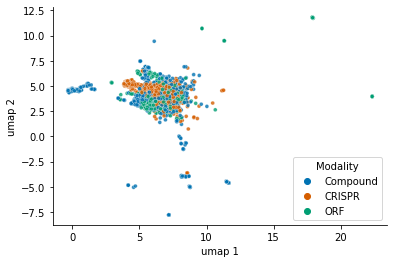

In [6]:
# U2OS 48h time point

U2OS_short_df = (
  X_embedded_df
  .query('Batch=="2020_11_04_CPJUMP1"')
  .query('Cell=="U2OS"')
  .query('time=="short"')
  .query('Density==100')
  .query('Antibiotics=="absent"')
)

sns.scatterplot(
    data=U2OS_short_df,
    x='umap 1', 
    y='umap 2', 
    hue=U2OS_short_df["Modality"],
    palette=color_discrete_map_seaborn,
    hue_order=['Compound', 'CRISPR', 'ORF'],
    alpha=0.8,
    s=15,
)

sns.despine()
plt.savefig('figures/U2OS_48.png')

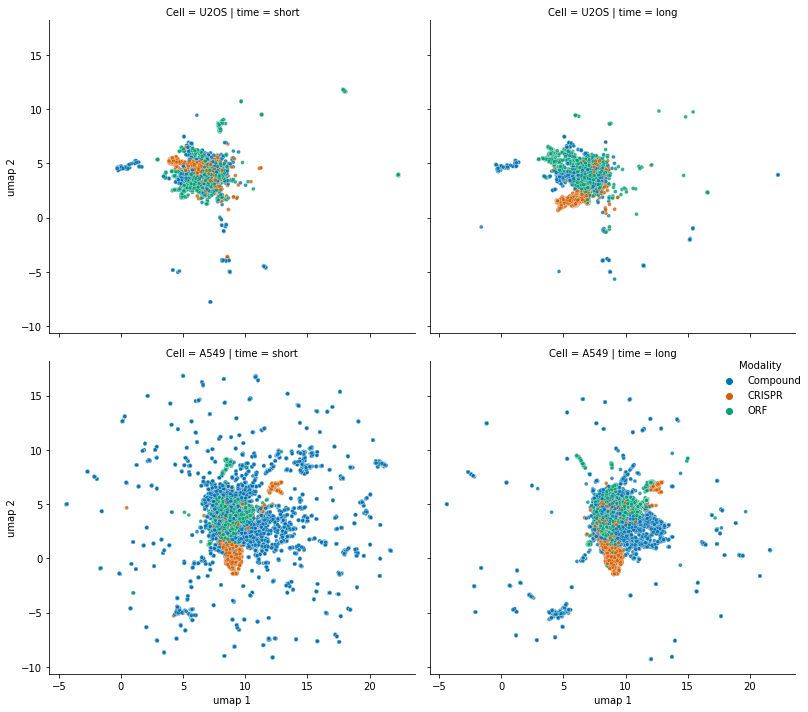

In [7]:
# Time vs. Cell type

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='time',
    row='Cell',
    col_order=['short', 'long'],
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.45])

plt.tight_layout()
plt.savefig('figures/4.umap_time_cell_type.png')

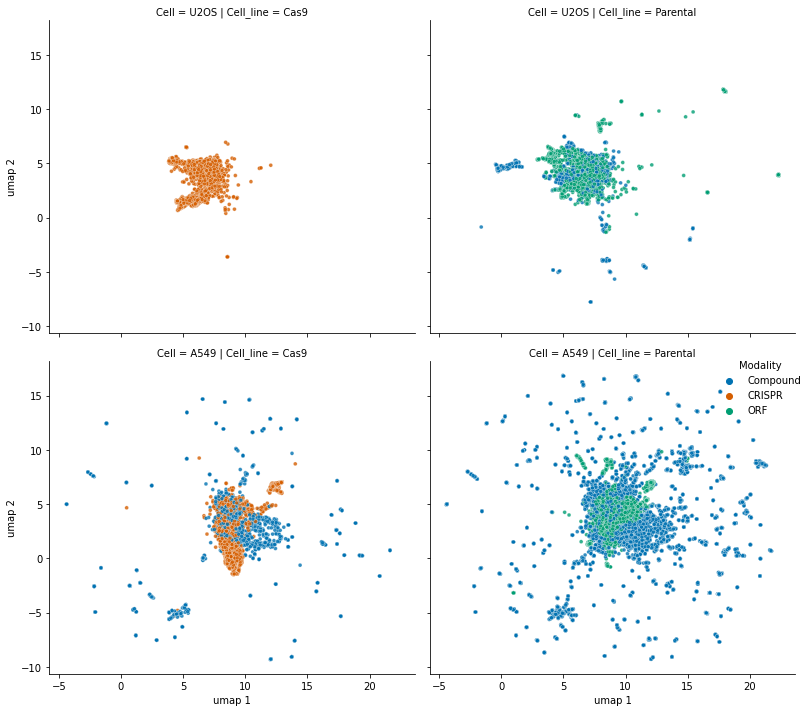

In [8]:
# Cell line vs. Cell Type

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='Cell_line',
    row='Cell',
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.45])

plt.tight_layout()
plt.savefig('figures/4.umap_cell_line_cell_type.png')

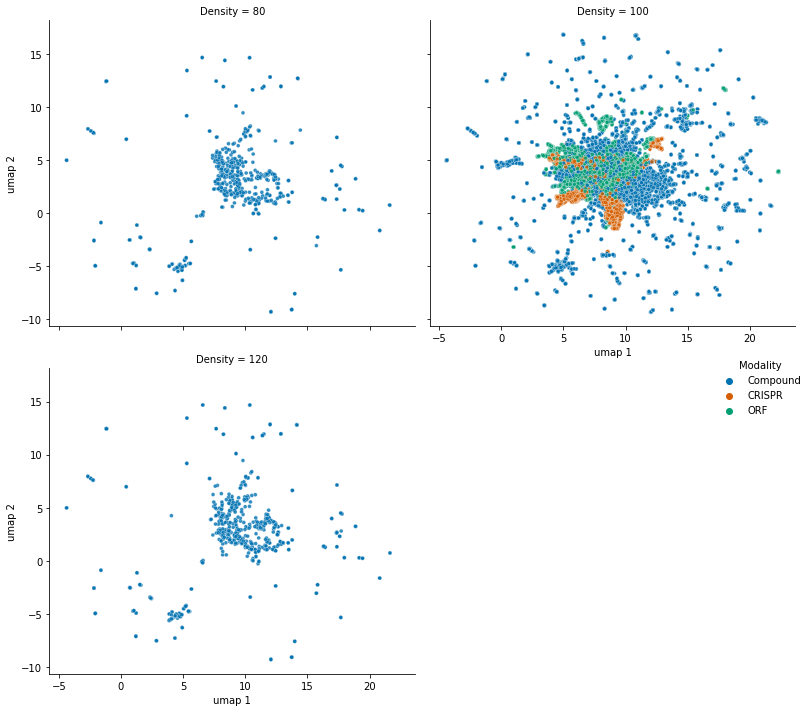

In [9]:
# Density

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='Density',
    col_wrap=2,
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.45])

plt.tight_layout()
plt.savefig('figures/4.umap_density.png')

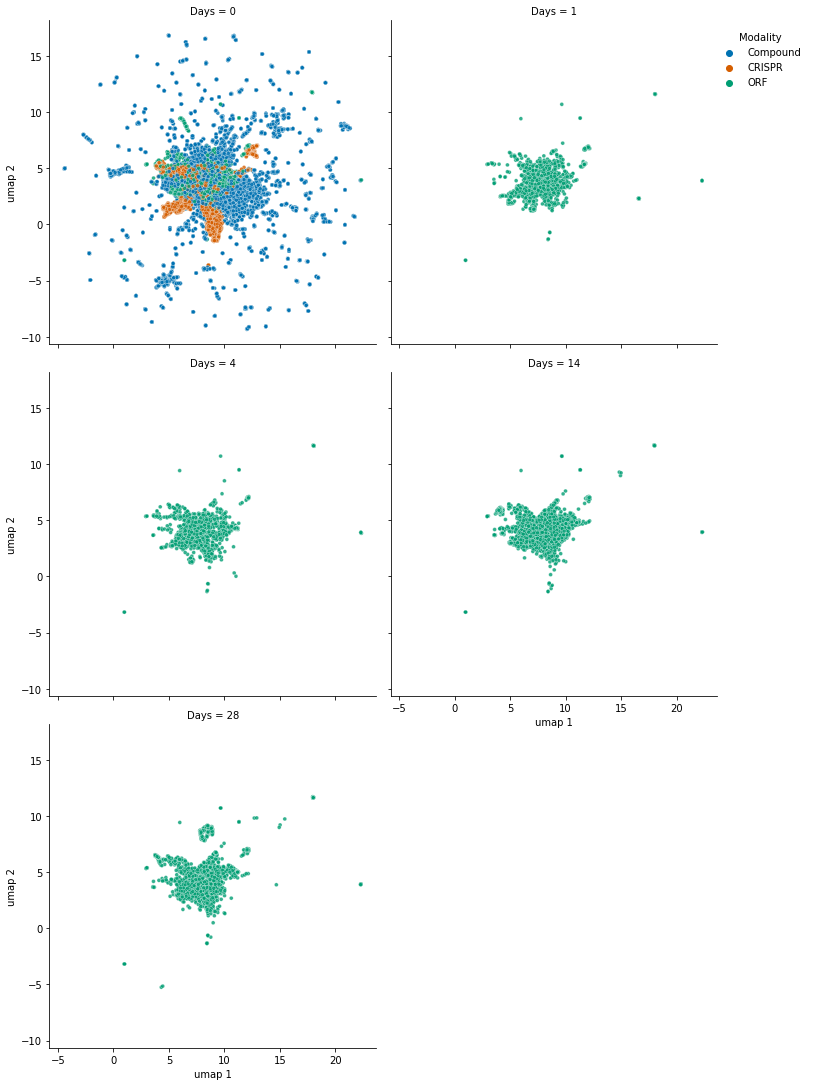

In [10]:
# Time delay

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='Days',
    col_wrap=2,
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.95])

plt.savefig('figures/4.umap_time_delay.png')

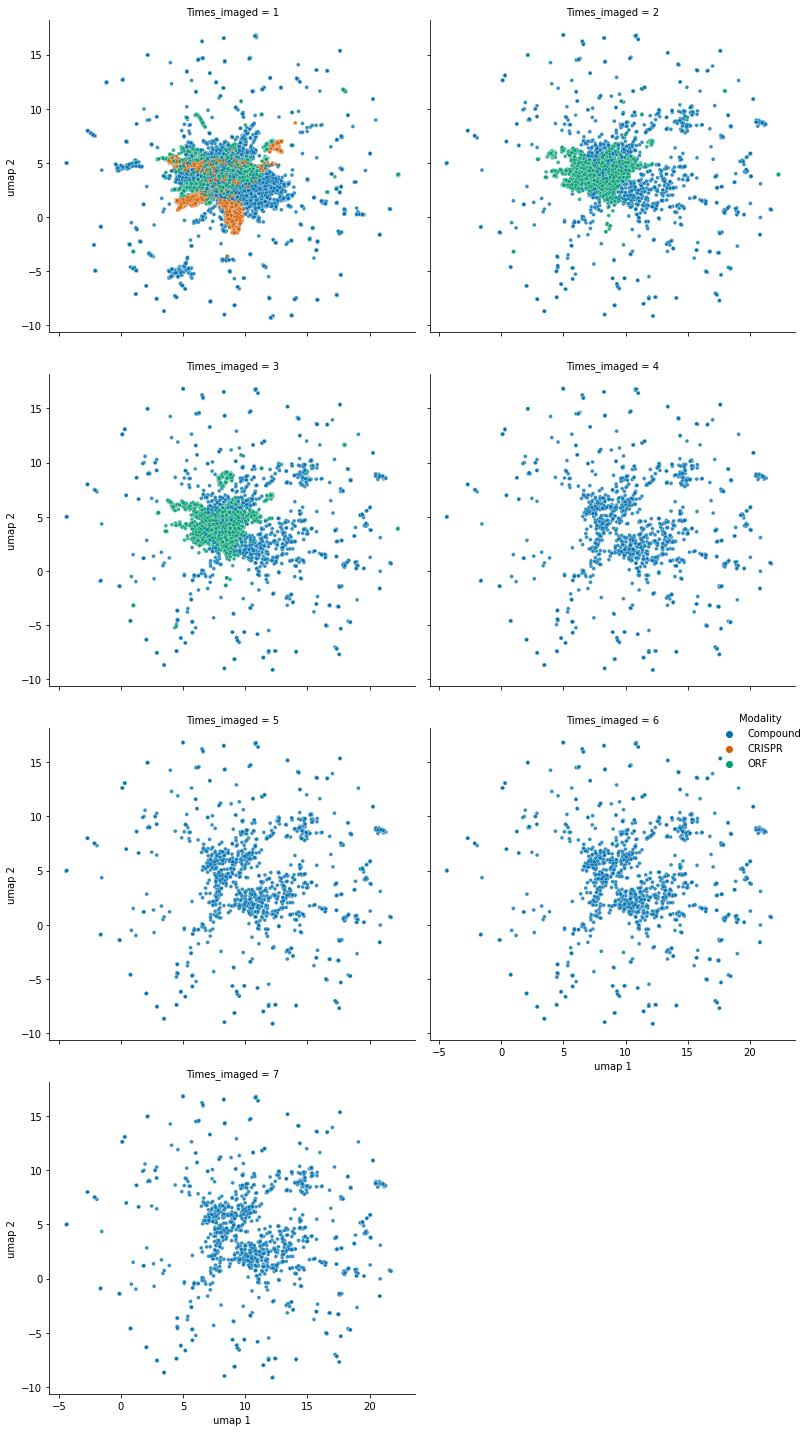

In [11]:
# Times imaged

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='Times_imaged',
    col_wrap=2,
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.48])

plt.tight_layout()
plt.savefig('figures/4.umap_times_imaged.png')

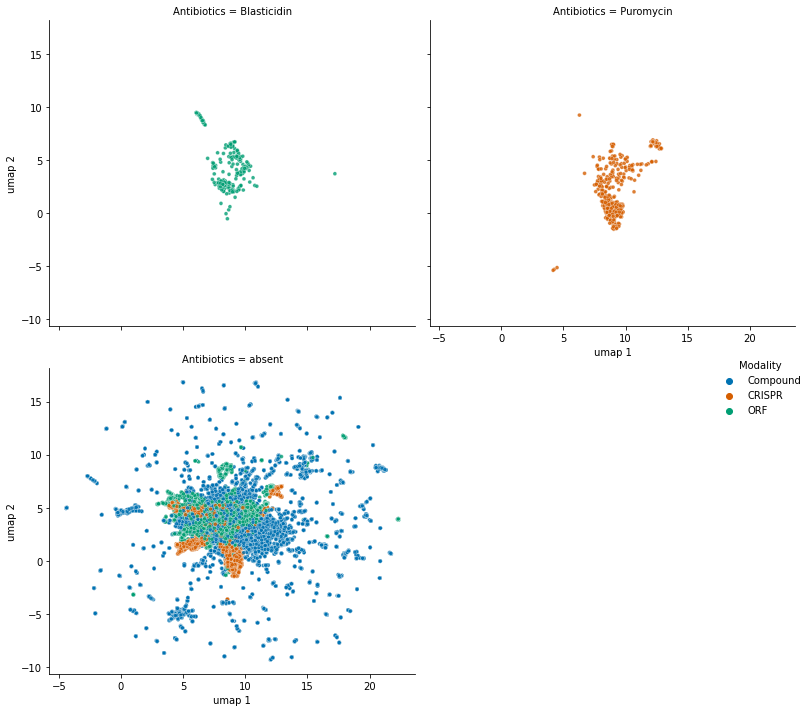

In [12]:
# Antibiotics

g = sns.relplot(
    data = X_embedded_df,
    x='umap 1', 
    y='umap 2', 
    hue='Modality',
    hue_order=['Compound', 'CRISPR', 'ORF'],
    kind='scatter',
    col='Antibiotics',
    col_wrap=2,
    col_order=['Blasticidin', 'Puromycin', 'absent'],
    alpha=0.8,
    s=15,
    palette=color_discrete_map_seaborn
)

leg = g._legend
leg.set_bbox_to_anchor([1,0.45])

plt.tight_layout()
plt.savefig('figures/4.umap_antibiotics.png')